In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import cv2
import matplotlib.image as mpimg
from matplotlib import path
from scipy.spatial.transform import Rotation 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dirdata = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek4AssignmentCode/data.mat'
data = sio.loadmat(dirdata)['data']
print(data.shape)

(1, 1)


In [3]:
def EssentialMatrixFromFundamentalMatrix(F,K):
#     E_ = np.matmul(np.matmul(K.T,F),np.linalg.inv(K))
    E_ = np.matmul(np.matmul(K.T,F),K)
#     E_ = np.matmul(np.matmul(K,F),K.T)
    u,s,vh = np.linalg.svd(E_)
    d = np.diag(np.array([1,1,0]))
#     print(s)
#     print(vh)
    E = np.matmul(np.matmul(u,d),vh.T)
    return E

In [4]:
x1 = data['x1'][0][0]; x2 = data['x2'][0][0]
x3 = data['x3'][0][0]; K = data['K'][0][0]
C = data['C'][0][0]; R = data['R'][0][0]
img1 = data['img1'][0][0].astype(np.uint8)
img2 = data['img2'][0][0].astype(np.uint8)
img3 = data['img3'][0][0].astype(np.uint8)

In [5]:
x1.shape

(429, 2)

In [6]:
F, mask = cv2.findFundamentalMat(x1,x2,cv2.FM_LMEDS)

In [7]:
F

array([[ 1.19586920e-07,  6.74009099e-06, -4.04513821e-03],
       [-5.11794316e-06, -6.15510087e-08, -2.58691694e-03],
       [ 3.01361581e-03,  8.95094934e-04,  1.00000000e+00]])

In [8]:
# We select only inlier points
pts1 = x1[mask.ravel()==1].astype(int)
pts2 = x2[mask.ravel()==1].astype(int)

In [9]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,_ = img1.shape
    img1 = cv2.cvtColor(img1.astype(np.uint8),cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2.astype(np.uint8),cv2.COLOR_BGR2GRAY)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

(-0.5, 1279.5, 959.5, -0.5)

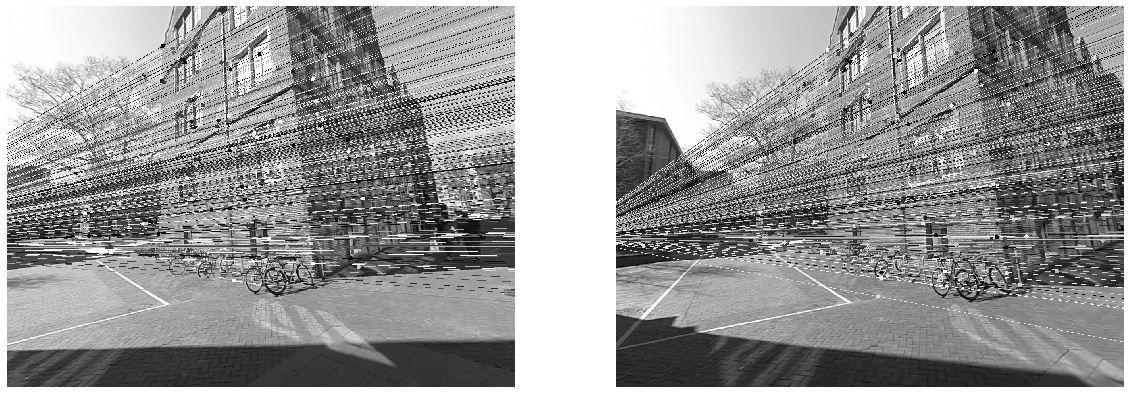

In [10]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img4,img5 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img6,img7 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(20,10)); plt.set_cmap('gray');
plt.subplot(121);plt.imshow(img4);  plt.axis('off')
plt.subplot(122);plt.imshow(img6); plt.axis('off')

In [11]:
retval, mask = cv2.findEssentialMat(x1,x2,K) 
print(retval.shape)
print(mask.shape)
print(retval)

(3, 3)
(429, 1)
[[ 0.00774956  0.34640943 -0.0645564 ]
 [-0.22481591 -0.00744797 -0.66738593]
 [ 0.05469857  0.61377678  0.00757697]]


In [12]:
E = EssentialMatrixFromFundamentalMatrix(F,K)
print(E)
print(np.linalg.norm(E,'fro'))
print(E/np.linalg.norm(E,'fro'))
print(np.linalg.norm(E/np.linalg.norm(E,'fro')))
print(E/np.linalg.norm(E,'fro')-retval)

[[-0.14846708  0.54219138  0.21187386]
 [-0.40091352 -0.28251471  0.8642522 ]
 [-0.12507959  0.78791806  0.12311649]]
1.4142135623730947
[[-0.10498208  0.3833872   0.14981744]
 [-0.28348867 -0.19976806  0.61111859]
 [-0.08844463  0.5571422   0.08705651]]
1.0
[[-0.11273164  0.03697777  0.21437384]
 [-0.05867276 -0.19232009  1.27850452]
 [-0.14314319 -0.05663458  0.07947954]]


In [13]:
np.hstack((np.eye(3),np.zeros((3,1))))

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [14]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [15]:
def computeA(P1,P2,x1,x2):
    u=x1[0];v=x1[1];up=x2[0];vp=x2[1]
    A = np.array([[v*P1[2,:]-P1[1,:]],
                 [u*P1[2,:]-P1[0,:]],
                 [vp*P2[2,:]-P2[1,:]],
                 [up*P2[2,:]-P2[0,:]]])
    return A
    
def LinearTrianglulation(K,C1,R1,C2,R2,x1,x2):
    P1 = np.matmul(K,np.hstack((R1,C1)))
    P2 = np.matmul(K,np.hstack((R2,C2)))
    X = []
    for i in range(x1.shape[0]):
        A = computeA(P1,P2,x1[i,:],x2[i,:])
        _,_,vh = np.linalg.svd(A.squeeze())
        X.append(vh.T[:3,-1].T/vh[3,3])
        
    return np.array(X)

In [16]:
X = LinearTrianglulation(K,np.zeros((3,1)),np.eye(3),C,R,x1,x2)
retbol,rvec3,tvec3 = cv2.solvePnP(X,x3,K,np.zeros((1,8)))

In [17]:
X

array([[ -1.0055386 ,  -1.32857464,  -7.69920036],
       [ -1.87854299,   3.94715861,  -8.97205199],
       [ 13.05186828,   7.03814836, -23.05462743],
       ...,
       [ -6.97429954,   6.03479821, -13.81903566],
       [ -4.49052414,   6.49837786, -11.74606477],
       [  5.19149125,   8.79153157, -14.50757745]])

In [18]:
print(rvec3)
print(tvec3)

[[ 0.03118612]
 [ 0.14210425]
 [-0.04286937]]
[[-1.64879751]
 [ 0.37228829]
 [ 1.0376512 ]]


In [19]:
r = Rotation.from_rotvec(rvec3.squeeze())
print(r.as_dcm())

[[ 0.9890054   0.04491679  0.14089287]
 [-0.0404936   0.99859751 -0.03410682]
 [-0.14222724  0.02802657  0.98943718]]


In [20]:
def reprojectionPts(X,K,R,C,R3,C3):
    x1p = np.matmul(K,X.T)
    x1p/=np.tile(x1p[2,:],(3,1))
    x2p = np.matmul(np.matmul(K,R),(X.T-np.tile(C,(1,X.shape[0]))))
    x2p/=np.tile(x2p[2,:],(3,1))
    x3p = np.matmul(np.matmul(K,R3),(X.T-np.tile(C3,(1,X.shape[0]))))
    x3p/=np.tile(x3p[2,:],(3,1))
    return x1p,x2p,x3p

In [21]:
x1p,x2p,x3p = reprojectionPts(X,K,R,C,r.as_dcm(),tvec3)

In [23]:
def DisplayCorrespondence(img,x,xp):
    plt.imshow(img)
    err = 0
    for i in range(x.shape[0]):
        plt.plot([xp[0,i],x[i,0]],[xp[1,i],x[i,1]],'r-')
        plt.plot(x[i,0],x[i,1],'bo')

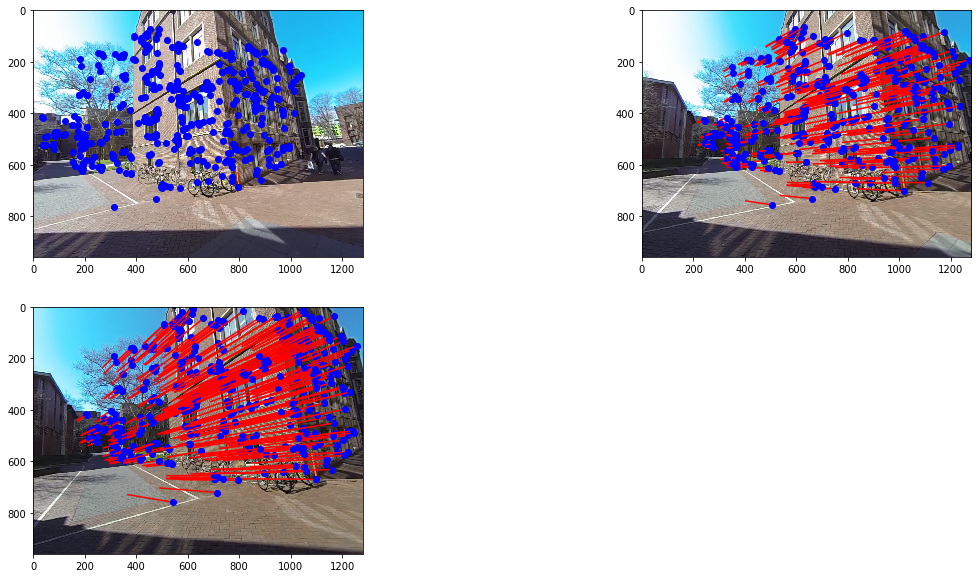

In [24]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
DisplayCorrespondence(img1,x1,x1p)
plt.subplot(2,2,2)
DisplayCorrespondence(img2,x2,x2p)
plt.subplot(2,2,3)
DisplayCorrespondence(img3,x3,x3p)

In [ ]:
def DisplayCameraPlane(C,R,windowScale):
    

In [60]:
def Display3D(Cset,Rset,X):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2])
    ax.view_init(270,90)
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2])
    ax.view_init(180,90)
    ax = fig.add_subplot(223, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2])
    ax.view_init(180,180)

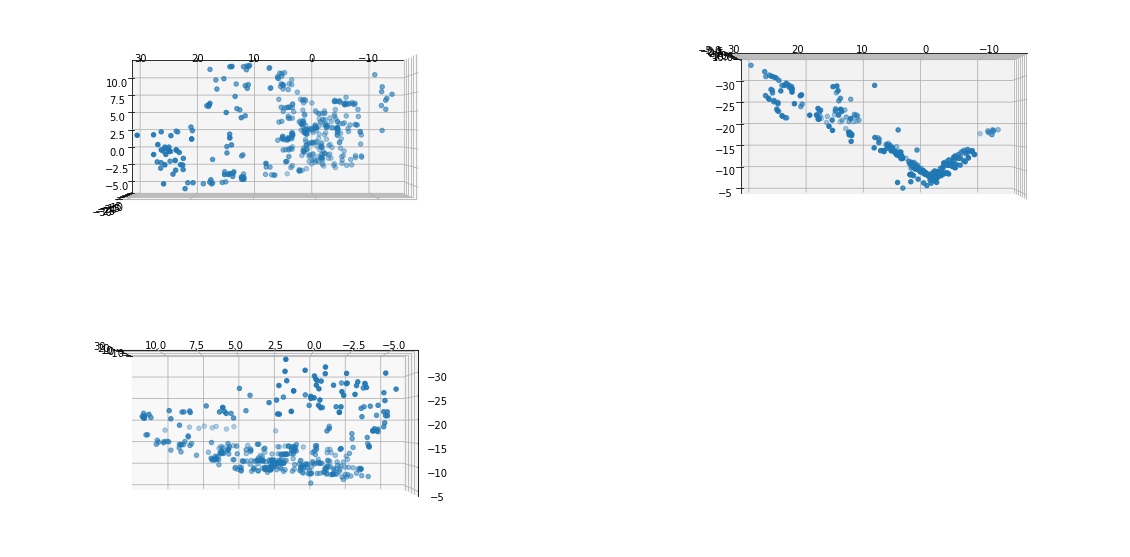

In [61]:
Display3D([],[],X)

In [ ]:
def nonLinearTriangulation(K,C1,R1,C2,R2,C3,R3,x1,x2,x3,X):
    